In [1]:
import random
import pylab as plt
import torch
import numpy as np
import torch.nn as nn

from tqdm.auto import tqdm
from sklearn import datasets
from dal_toolbox.models.deterministic.train import train_one_epoch
from dal_toolbox.models.deterministic.evaluate import evaluate

In [2]:
X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
dset = torch.utils.data.TensorDataset(X, y)

In [3]:
def stochasitc_augmentation(X: torch.tensor, noise: float = 0):
    return X + torch.randn_like(X)*noise

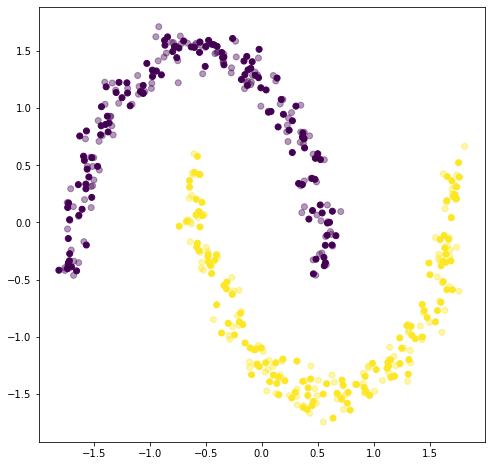

In [4]:
# What are useful values for noise?

X_trans = stochasitc_augmentation(X, 0.05)

fix = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(X_trans[:,0], X_trans[:,1], c=y, alpha=0.4)
plt.show()

In [5]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=1)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [6]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(2, 100)
        self.layer2 = nn.Linear(100, 50)
        self.fc = nn.Linear(50, 2)
        self.act = nn.functional.relu

        self.layer3 = nn.Linear(50, 25)
        self.layer4 = nn.Linear(25, 10)

    def forward(self, X, get_projections=False):
        X = self.layer1(X)
        X = self.act(X)
        X = self.layer2(X)
        #X = self.act(X)

        if get_projections:
            X = self.layer3(X)
            X = self.act(X)
            X = self.layer4(X)
            return X
        
        X = self.fc(X)
        return X

In [32]:
def train_one_epoch_simclr(model, optimizer, criterion_sup, criterion_unsup, dataloaders, lmbd, device='cuda'):
    model.train()
    model.to(device)
    criterion_sup.to(device)
    criterion_unsup.to(device)

    total_loss_sup, total_loss_unsup, n_samples_l, n_samples_ul = 0, 0, 0, 0

    # Train the epoch
    for (x_l, y_l), (x_ul, _) in zip(dataloaders['labeled'], dataloaders['unlabeled']):
        x_l, y_l, x_ul = x_l.to(device), y_l.to(device), x_ul.to(device)
        bs_l, bs_ul = x_l.shape[0], x_ul.shape[0]

        # Stochastic transformation for unlabeled data
        x_ul_A, x_ul_B = stochasitc_augmentation(x_ul, noise=random.uniform(0, 0.05)), stochasitc_augmentation(x_ul, noise=random.uniform(0, 0.05))
        x_ul = torch.cat([x_ul_A, x_ul_B], dim=0)

        # Supervised loss
        out_l = model(x_l, get_projections=False)
        loss_l = criterion_sup(out_l, y_l)

        # Unsupervised loss
        out_ul = model(x_ul, get_projections=True)
        loss_ul = criterion_unsup(out_ul)

        loss = loss_l + lmbd*loss_ul

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_sup += loss_l.item() * bs_l
        total_loss_unsup += loss_ul.item() * bs_ul * 2

        n_samples_l += bs_l
        n_samples_ul += bs_ul * 2

    return total_loss_sup/n_samples_l, total_loss_unsup/n_samples_ul

In [33]:
#class NTXent(nn.Module):
#    def __init__(self, T):
#        super(NTXent, self).__init__()
#        self.sim = nn.CosineSimilarity(dim=0)
#        self.T = T
#        self.device='cuda'
#
#    def forward(self, X, batch_size):
#        total_loss = torch.tensor(0, dtype=torch.float).to(self.device)
#        for i in range(2*batch_size):
#            j = (i + batch_size) if i < batch_size else (i - batch_size)
#            loss = - torch.log( 
#                torch.exp(self.sim(X[i], X[j])/self.T) /
#                torch.sum(torch.tensor([torch.exp(self.sim(X[i], X[k])/self.T) for k in range(2*batch_size) if k!=i]).to(self.device))
#            )
#            total_loss += loss
#        return torch.mean(total_loss)

In [34]:
LARGE_NUM = 1e9

class NTXent(nn.Module):
    def __init__(self, T):
        super(NTXent, self).__init__()
        self.sim = nn.CosineSimilarity(dim=0)
        self.ce = nn.CrossEntropyLoss()
        self.T = T
        self.device = 'cuda'
        self.hidden_norm = True

    def forward(self, hidden):
        if self.hidden_norm:
            hidden = torch.linalg.vector_norm(hidden, ord=2, dim=-1)
        hidden1, hidden2 = torch.chunk(hidden, 2, 0)
        batch_size = hidden1.shape[0]

        labels = torch.tensor([i+batch_size if i < batch_size else i - batch_size for i in range(batch_size * 2)]).to(self.device)
        masks = torch.tensor([i for i in range(batch_size)]).to(self.device)

        logits_aa = torch.matmul(hidden1.reshape(-1, 1), hidden1.reshape(1, -1)) / self.T
        logits_aa = logits_aa - masks * LARGE_NUM
        logits_bb = torch.matmul(hidden2.reshape(-1, 1), hidden2.reshape(1, -1)) / self.T
        logits_bb = logits_bb - masks * LARGE_NUM
        logits_ab = torch.matmul(hidden1.reshape(-1, 1), hidden2.reshape(1, -1)) / self.T
        logits_ba = torch.matmul(hidden2.reshape(-1, 1), hidden1.reshape(1, -1)) / self.T

        logits_a = torch.cat([logits_ab, logits_aa], 1).softmax(-1)
        logits_b = torch.cat([logits_ba, logits_bb], 1).softmax(-1)

        loss_a = self.ce(logits_a, labels)
        loss_b = self.ce(logits_b, labels)
        loss = loss_a + loss_b

        return loss

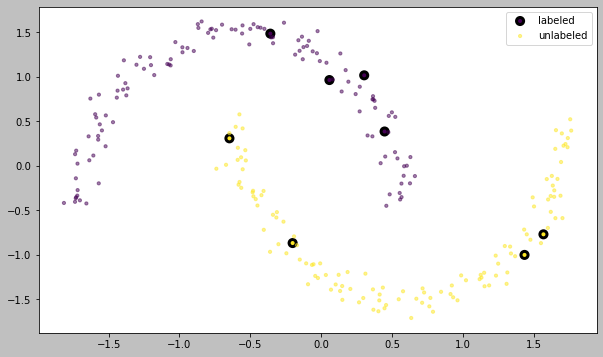

In [35]:
# Test on Semi supervised classification task
X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

random.seed(1)
indices_class0 = [i for i in range(len(y)) if y[i] == 0]
indices_class1 = [i for i in range(len(y)) if y[i] == 1]
labeled_indices = random.sample(indices_class0, k=4) + random.sample(indices_class1, k=4)
unlabeled_indices = [i for i in range(X.shape[0]) if i not in labeled_indices]

X_labeled, y_labeled = X[labeled_indices], y[labeled_indices]
X_unlabeled, y_unlabeled = X[unlabeled_indices], y[unlabeled_indices]

labeled_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
# Using labeled and unlabeled data for unsupervised learning
unlabeled_ds = torch.utils.data.TensorDataset(X, y)

plt.figure(figsize=(10,6), facecolor='silver')
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=50, edgecolors='black', linewidths=3, label='labeled')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=10, alpha=0.5, label='unlabeled')
plt.legend()
plt.show()

In [36]:
n_epochs = 100
batch_size = 32
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4
lmbd = 1
u_ratio = 1

model = NN()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
dataloader_sup = torch.utils.data.DataLoader(labeled_ds, batch_size=batch_size)
dataloader_unsup = torch.utils.data.DataLoader(unlabeled_ds, batch_size=u_ratio * batch_size)
criterion_sup = nn.CrossEntropyLoss()
criterion_unsup = NTXent(T=1)

dataloaders = {
    'labeled':dataloader_sup,
    'unlabeled':dataloader_unsup
}

history = []

for i in tqdm(range(n_epochs)):
    loss_sup, loss_unsup = train_one_epoch_simclr(model, optimizer, criterion_sup, criterion_unsup, dataloaders, lmbd)
    test_acc = evaluate(model, dataloader_unsup, {}, criterion_sup, device='cuda')['test_acc1']
    history.append(
        {
        'loss_sup':loss_sup,
        'loss_unsup':loss_unsup,
        'test_acc':test_acc
        }
    )
    if (i % 5 == 0) or (i == n_epochs-1):
        plot_contour(model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
        plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Expected input batch_size (32) to match target batch_size (64).

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot([h['loss_sup'] for h in history])
ax[0].set_title("Supervised Loss")
ax[1].plot([h['loss_unsup'] for h in history])
ax[1].set_title("Unupervised Loss")
ax[2].plot([h['test_acc'] for h in history])
ax[2].set_title("Test Accuracy")
plt.show()

In [ ]:
plot_contour(model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)